# MIMIC IV CNN Evaluation - Baseline Model

### Set Up 

In [18]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, average_precision_score, precision_recall_curve
from tableone import TableOne

**Column Definitions**
- subject_id: *patient unique identifier*
- study_id: *study of patient (x-ray instance)*
- dicom_id: *individual image ID*
- split: *train-validate-test split*
- path: *image path*
- hadm_id: *hospital admission id*
- admittime: *time of hospital admission*
- dischtime: *time of hospital discharge*
- deathtime: *time of death*
- admission_type: *admission type*
- admission_location: *admission location*
- discharge_location: *discharge location* 
- insurance: *patient's insurance type [Medicaid, Medicare, Other (private)]*
- language: *patient's native language*
- marital_status: *patient's marital status*
- race: *patient's race*
- edregtime: *in time of ER admittance*
- edouttime: *out time of ER admittance*
- hospital_expire_flag: *whether they died or not*
- gender: *patient's gender*
- anchor_age: *age*
- anchor_year: *shifted year by same delta*
- anchor_year_group: *bins of shifted years*
- dod: *death of death*
- Diagonses (values[-1.0, 0.0, 1.0])
    - Atelectasis
    - Cardiomegaly
    - Consolidation
    - Edema
    - Enlarged Cardiomediastinum
    - Fracture
    - Lung Lesion
    - Lung Opacity
    - No Finding
    - Pleural Effusion
    - Pleural Other
    - Pneumonia
    - Pneumothorax
    - Support Devices
- Probability of Diagnosis (0,1)
    - pred_Atelectasis
    - pred_Cardiomegaly
    - pred_Consolidation
    - pred_Edema
    - pred_Enlarged Cardiomediastinum
    - pred_Fracture
    - pred_Lung Lesion
    - pred_Lung Opacity
    - pred_No Finding
    - pred_Pleural Effusion
    - pred_Pleural Other
    - pred_Pneumonia
    - pred_Pneumothorax
    - pred_Support Devices

    

In [19]:
base_path = '/home/zzaiman/local/CS334FinalProject/final_repo'

In [60]:
results_baseline = pd.read_csv(os.path.join(base_path, 'runs/run1/results.csv'))
results_focal = pd.read_csv(os.path.join(base_path, 'runs/run4/results_focal_loss.csv'))
admissions = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/admissions.csv')
patients = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/hosp/patients.csv')

In [45]:
results_baseline.shape

(5159, 33)

In [46]:
results_focal.shape

(3403, 42)

In [47]:
# filter on frontals only 
focal_did = results_focal['dicom_id'].unique()
results_baseline = results_baseline[results_baseline['dicom_id'].isin(focal_did)].reset_index(drop=True)

In [48]:
results_baseline.shape

(3403, 33)

In [26]:
results_baseline.columns

Index(['subject_id', 'study_id', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum', 'Fracture',
       'Lung Lesion', 'Lung Opacity', 'No Finding', 'Pleural Effusion',
       'Pleural Other', 'Pneumonia', 'Pneumothorax', 'Support Devices',
       'dicom_id', 'split', 'path', 'pred_Atelectasis', 'pred_Cardiomegaly',
       'pred_Consolidation', 'pred_Edema', 'pred_Enlarged Cardiomediastinum',
       'pred_Fracture', 'pred_Lung Lesion', 'pred_Lung Opacity',
       'pred_No Finding', 'pred_Pleural Effusion', 'pred_Pleural Other',
       'pred_Pneumonia', 'pred_Pneumothorax', 'pred_Support Devices'],
      dtype='object')

In [27]:
results_baseline.shape

(3403, 33)

### Overall Evaluation

#### **1. Loss Plots**

Since we are running a multi-class model, we will evaluate our model performance individually on each label. There are multiple ways we can do this. First, we can make loss plots for each label (we are minimizing cross-entropy loss here).

In [28]:
labels = 'Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pleural Other,Pneumonia,Pneumothorax,Support Devices'.split(',')
labels = np.array(labels)
preds = pickle.load(open(os.path.join(base_path, 'runs/run1/predictions'), 'rb'))
hist = pickle.load(open(os.path.join(base_path, 'runs/run1/train_hist'), 'rb'))

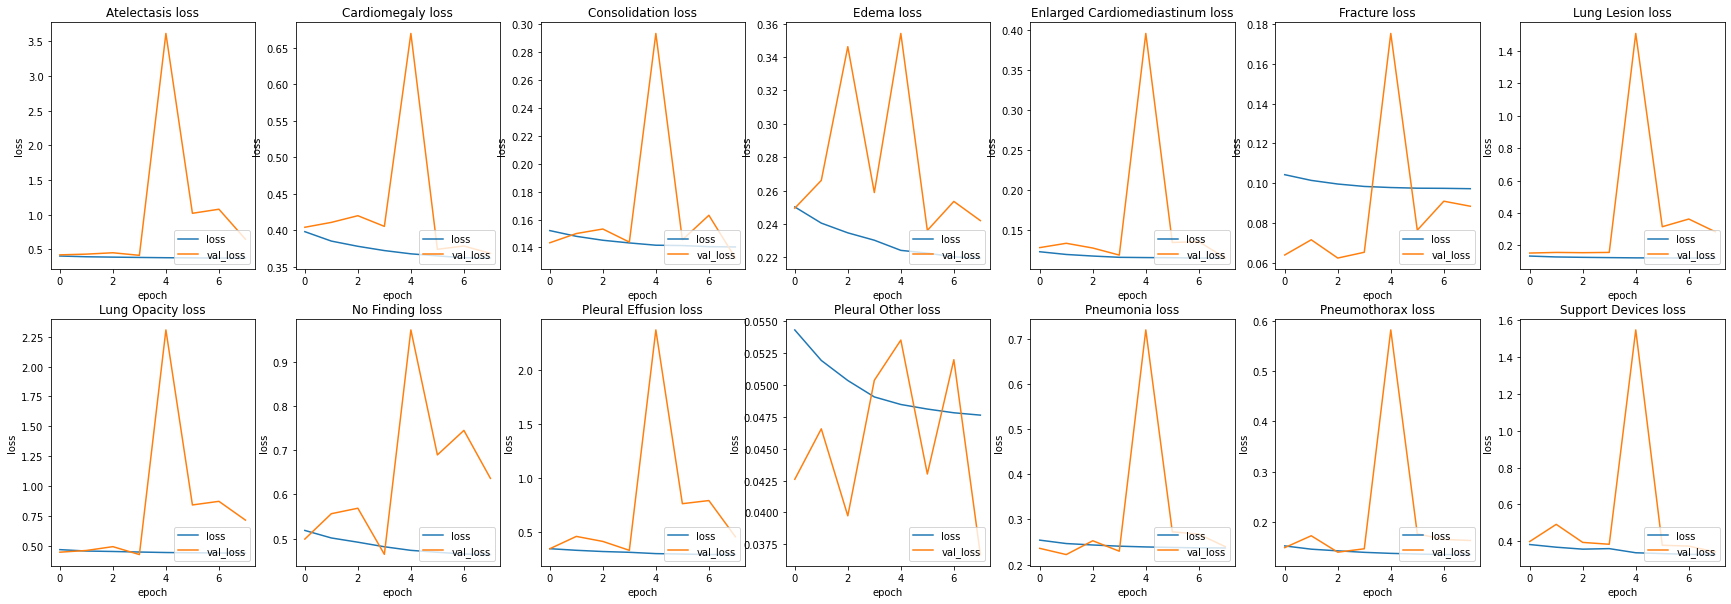

In [29]:
# Loss Plots
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
for i, lab in enumerate(labels):
    loss = hist[f'dense_{str(i+1)}_loss']
    val_loss = hist[f'val_dense_{str(i+1)}_loss']
    title = f'{lab} loss'

    if i < 7:
        x = 0
    else:
        x = 1
    
    if i < 7:
        y = i
    else:
        y = i - 7

    ax[x, y].plot(loss, label='loss')
    ax[x, y].plot(val_loss, label='val_loss')
    ax[x, y].title.set_text(title)
    ax[x, y].legend(loc=4)
    ax[x, y].set_xlabel('epoch')
    ax[x, y].set_ylabel('loss')

plt.savefig('baseline_loss_plots.png')

#### **2. AUROC**

The second way we can assess our model performance is by plotting the AUROC curve for each label. We can find the overall AUC values for each label as well.

In [30]:
# Function to calculate ROC
def calc_roc(df, labels):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)}', color='red')
        min = otpr.min()
        ax[x, y].fill_between(otpr,min,ofpr,alpha=0.5, color='red')
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('TPR')
        ax[x, y].set_ylabel('FPR')

In [31]:
# Calculates the AUROC or PRAUC score.
def calc_overall_auc(df, labels, callback):
    auc = {}
    for lab in labels:
        ytrue = df[lab]
        ypred = df['pred_'+lab]
        tauc = callback(ytrue, ypred)
        auc[lab] = tauc

    return auc

In [32]:
# Overall ROCAUC Scores for the baseline model 
calc_overall_auc(results_baseline, labels, roc_auc_score)

{'Atelectasis': 0.7174233060674656,
 'Cardiomegaly': 0.7536019680608582,
 'Consolidation': 0.6876403093040657,
 'Edema': 0.8034342130854509,
 'Enlarged Cardiomediastinum': 0.6079561542751726,
 'Fracture': 0.5949107774219042,
 'Lung Lesion': 0.665954039312856,
 'Lung Opacity': 0.6541904231317837,
 'No Finding': 0.7731797624998052,
 'Pleural Effusion': 0.852066071555756,
 'Pleural Other': 0.7445727592434178,
 'Pneumonia': 0.6180466002204684,
 'Pneumothorax': 0.7206569999437981,
 'Support Devices': 0.8482131555630564}

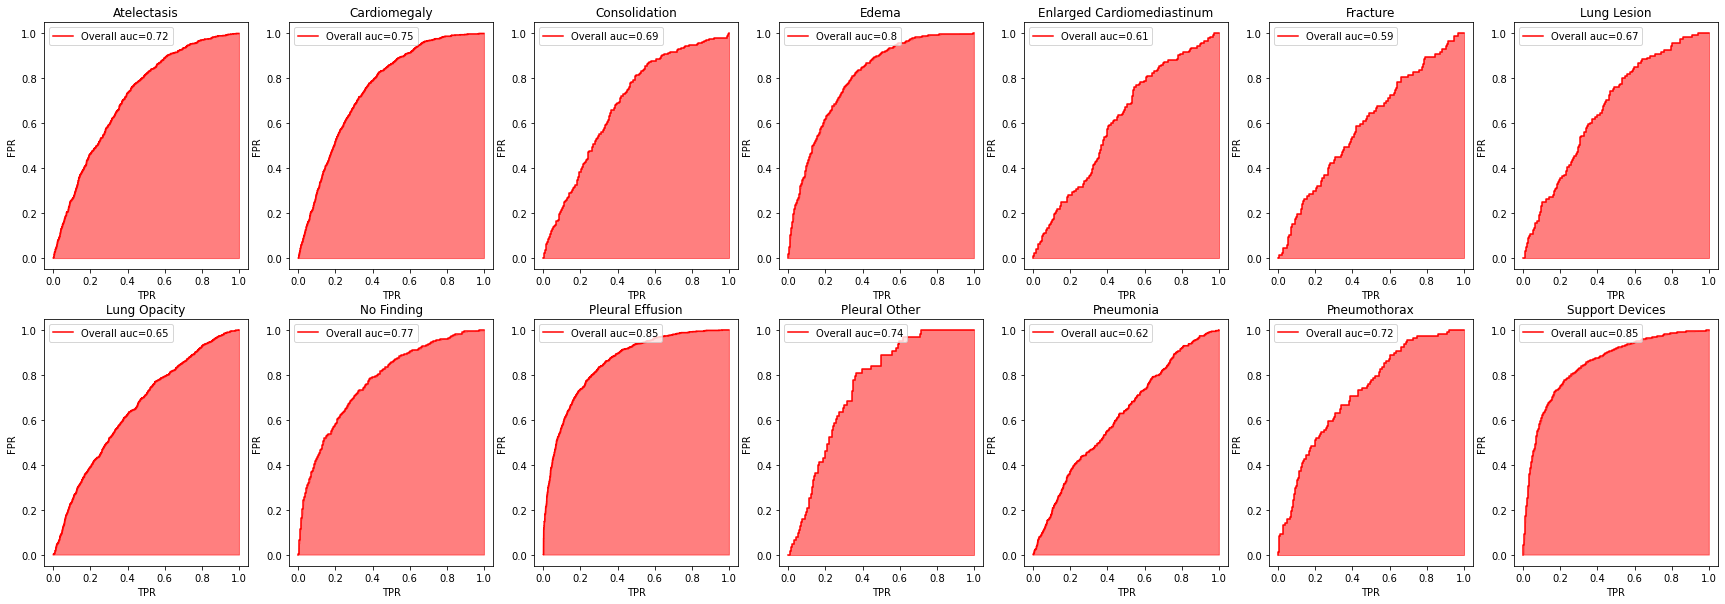

In [33]:
calc_roc(results_baseline, labels)
plt.savefig('baseline_roc_plots.png')

##### Class Imbalance

The above AUROC curves and overall AUC scores for each label are relatively high, indicating good model performance. However we know that there is likely a large class imbalance in this dataset, since only a relatively few number of people will have a lung disease in one of these 14 categories. We can confirm this by looking at the class ratios for each diagonsis label.

In [34]:
lab_imb = {}
for lab in labels:
    a = results_baseline[lab].value_counts()
    ratio = round(a[1.0]/a[0.0],3)
    lab_imb[lab] = ratio

lab_imb

{'Atelectasis': 0.29,
 'Cardiomegaly': 0.357,
 'Consolidation': 0.066,
 'Edema': 0.271,
 'Enlarged Cardiomediastinum': 0.044,
 'Fracture': 0.026,
 'Lung Lesion': 0.037,
 'Lung Opacity': 0.476,
 'No Finding': 0.211,
 'Pleural Effusion': 0.474,
 'Pleural Other': 0.019,
 'Pneumonia': 0.112,
 'Pneumothorax': 0.033,
 'Support Devices': 0.552}

#### **3. AUPRC**

As we can see from the above dictionary, there is a large class imbalance in every diagnosis label. This means that it is a good idea to also plot AUPRC curves for each diagnosis, since they tend to be more robust against class imbalance.

In [35]:
def calc_auprc(df, labels):
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7

        opre, orec, _ = precision_recall_curve(df[lab], df['pred_'+lab])
        avg_pre = average_precision_score(df[lab], df['pred_'+lab])
        ax[x, y].plot(orec, opre, label=f'Average Precision={round(avg_pre, 2)}')
        min = opre.min()
        ax[x, y].fill_between(orec,min,opre,alpha=0.5)
        ax[x, y].title.set_text(lab)
        ax[x, y].legend(loc=2)
        ax[x, y].set_xlabel('True Positive Rate (Recall)')
        ax[x, y].set_ylabel('Precision')

In [36]:
# Overall Average Precision Score on baseline.
calc_overall_auc(results_baseline, labels, average_precision_score)

{'Atelectasis': 0.3839119301727999,
 'Cardiomegaly': 0.4651208055286225,
 'Consolidation': 0.11400835121206604,
 'Edema': 0.5067071848392836,
 'Enlarged Cardiomediastinum': 0.06109919807297073,
 'Fracture': 0.036690644889493876,
 'Lung Lesion': 0.06156255430307446,
 'Lung Opacity': 0.4493805089243925,
 'No Finding': 0.45445047062450017,
 'Pleural Effusion': 0.7365921042105719,
 'Pleural Other': 0.038231196935022,
 'Pneumonia': 0.1490187757002459,
 'Pneumothorax': 0.09007001752744301,
 'Support Devices': 0.7572962975560126}

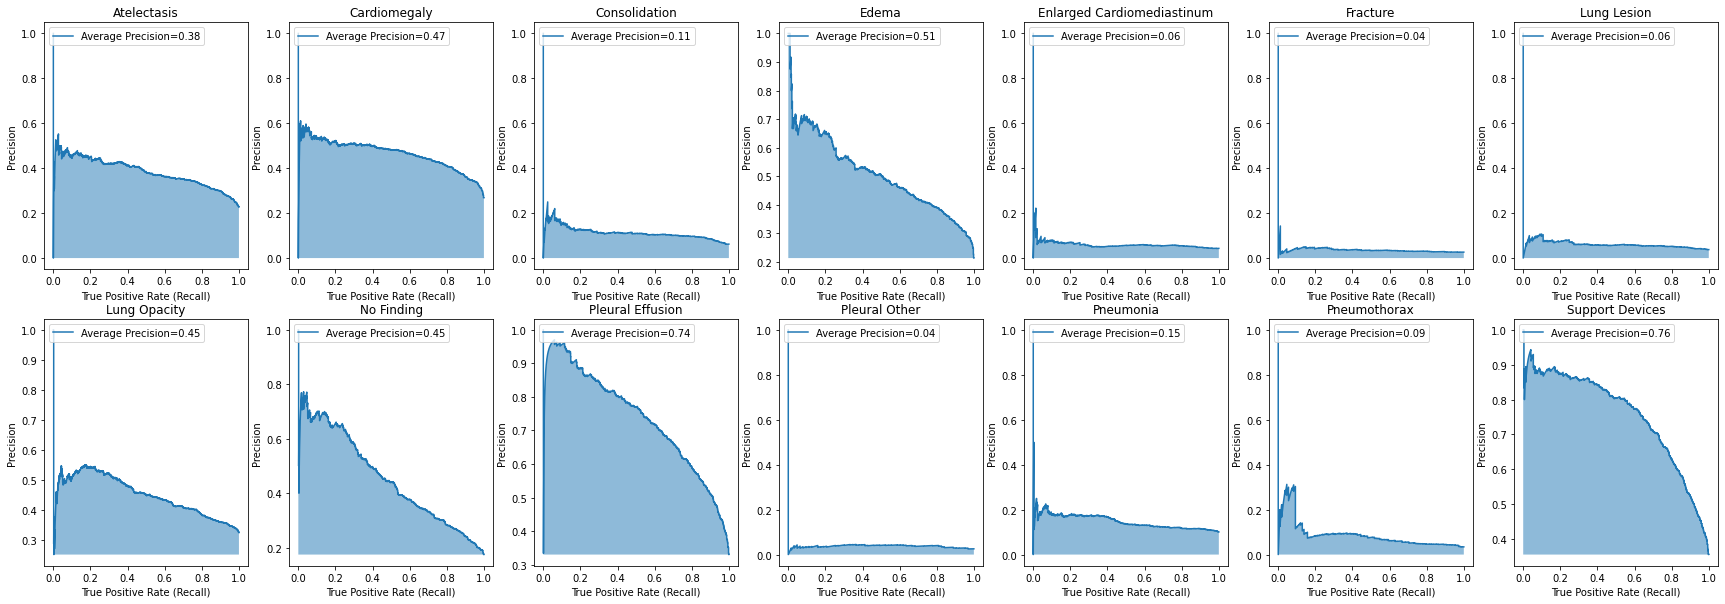

In [38]:
calc_auprc(results_baseline,labels)
plt.savefig('baseline_prc_plot.png')

## Stratification

We will be stratifying our analysis of the model by a few different relevant features, including race, sex, insurance status (Medicare, Medicaid, Private), ICU status and age.

In [50]:
results_baseline = results_baseline.merge(patients, on='subject_id')
results_baseline.shape

(3403, 43)

In [53]:
admissions.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admission_location', 'discharge_location',
       'insurance', 'language', 'marital_status', 'race', 'edregtime',
       'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [63]:
metadata = pd.read_csv('../../../../physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv')


In [ ]:
results_baseline['admittime'] = pd.to_datetime(results_baseline['admittime'])
results_baseline['dischtime'] = pd.to_datetime(results_baseline['dischtime'])
metadata = metadata[['subject_id', 'study_id', 'StudyDate']]
metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')

KeyError: 'admittime'

: 

In [64]:
# Merge with admissions and select the admission for each patient where the study was taken.
results_baseline = results_baseline.merge(admissions, on='subject_id', how='left')
results_baseline = results_baseline.merge(metadata, on='study_id', how='left')
results_baseline = results_baseline[(results_baseline['StudyDate'] <= results_baseline['intime']) & (results_baseline['StudyDate'] <= results_baseline['outime'])]


KeyError: 'subject_id'

In [58]:
results_baseline.shape

(3890847, 73)

### 1. Race

We are interested in seeing if stratfying by race impacts the model's performance. 

*It is important to note that there is a lot of literature both for and against the idea that American conceptions of race are actually linked to any kind of genetic variation that impacts health, or if race is simply a proxy for a confluence of socioeconomic factors that contribute to health disparities. This project will not presume either orientation/explanation, but will simply analyze correlations between the model diagnoses at hand and designated Census-backed racial categories.*

#### Preprocessing

First, we can look at the racial categorization schema of the MIMIC database. We can see that the MIMIC database does not align with US Census categories on race, and includes more specific information on ethnicity. We can also see that white people are heavily overrepresented in the database. 

In [28]:
results_baseline['race'].value_counts()

WHITE                                 33097
BLACK/AFRICAN AMERICAN                12727
HISPANIC/LATINO - PUERTO RICAN         3736
HISPANIC OR LATINO                     2123
BLACK/CAPE VERDEAN                     1781
OTHER                                  1414
ASIAN - SOUTH EAST ASIAN               1146
ASIAN - ASIAN INDIAN                   1144
ASIAN - CHINESE                         877
WHITE - OTHER EUROPEAN                  863
WHITE - EASTERN EUROPEAN                836
BLACK/CARIBBEAN ISLAND                  667
WHITE - RUSSIAN                         299
AMERICAN INDIAN/ALASKA NATIVE           240
SOUTH AMERICAN                          148
PATIENT DECLINED TO ANSWER              138
MULTIPLE RACE/ETHNICITY                 112
UNKNOWN                                  73
HISPANIC/LATINO - CENTRAL AMERICAN       66
HISPANIC/LATINO - GUATEMALAN             35
PORTUGUESE                               18
UNABLE TO OBTAIN                         12
HISPANIC/LATINO - DOMINICAN     

This is why we can bucket the races. This will prevent some buckets, particularly of minority patients, of being too small relative to the number of white patients and will also facilitate our data analysis process. The buckets we will choose are:

    * White
    * Asian + Pacific Islander 
    * Hispanic/Latino
    * Black/African American
    * Unknown/Other (including Native American/American Indian, Multiple Ethnicites, Patient Declined to Specify)

In [29]:
# bucket races for baseline model
def label_races(row):
    if row['race'] in ['BLACK/AFRICAN AMERICAN', 'BLACK/CAPE VERDEAN', 'BLACK/CARIBBEAN ISLAND']:
        return 'black'
    if row['race'] in ['WHITE', 'WHITE - OTHER EUROPEAN', 'WHITE - EASTERN EUROPEAN', 'WHITE - RUSSIAN', 'PORTUGUESE']:
        return 'white'
    if row['race'] in ['HISPANIC OR LATINO', 'HISPANIC/LATINO - CENTRAL AMERICAN', 'HISPANIC/LATINO - GUATEMALAN', 'HISPANIC/LATINO - PUERTO RICAN', 'HISPANIC/LATINO - DOMINICAN', 'SOUTH AMERICAN']:
        return 'hispanic/latino'
    if row['race'] in ['ASIAN - ASIAN INDIAN', 'ASIAN - KOREAN', 'ASIAN - CHINESE', 'ASIAN', 'ASIAN - SOUTH EAST ASIAN']:
        return 'asian'
    return 'other'

In [30]:
# distribution of new race buckets
results_baseline['race_bucket'] = results_baseline.apply(lambda row: label_races(row), axis=1)
results_baseline['race_bucket'].value_counts()

white              35113
black              15175
hispanic/latino     6118
asian               3176
other               1989
Name: race_bucket, dtype: int64

 We can look at the distribution of records by race bucket for each of the 14 diagonses. This will help us get a better sense of what diagnoses are more commonly found in certain race buckets. 

In [31]:
# filter on relevant rows
race_dist_df = results_baseline.filter(['subject_id', 'race_bucket', 'Atelectasis', 'Cardiomegaly',
       'Consolidation', 'Edema', 'Enlarged Cardiomediastinum',
       'Fracture', 'Lung Lesion', 'Lung Opacity',
       'No Finding', 'Pleural Effusion', 'Pleural Other',
       'Pneumonia', 'Pneumothorax', 'Support Devices' ], axis=1)

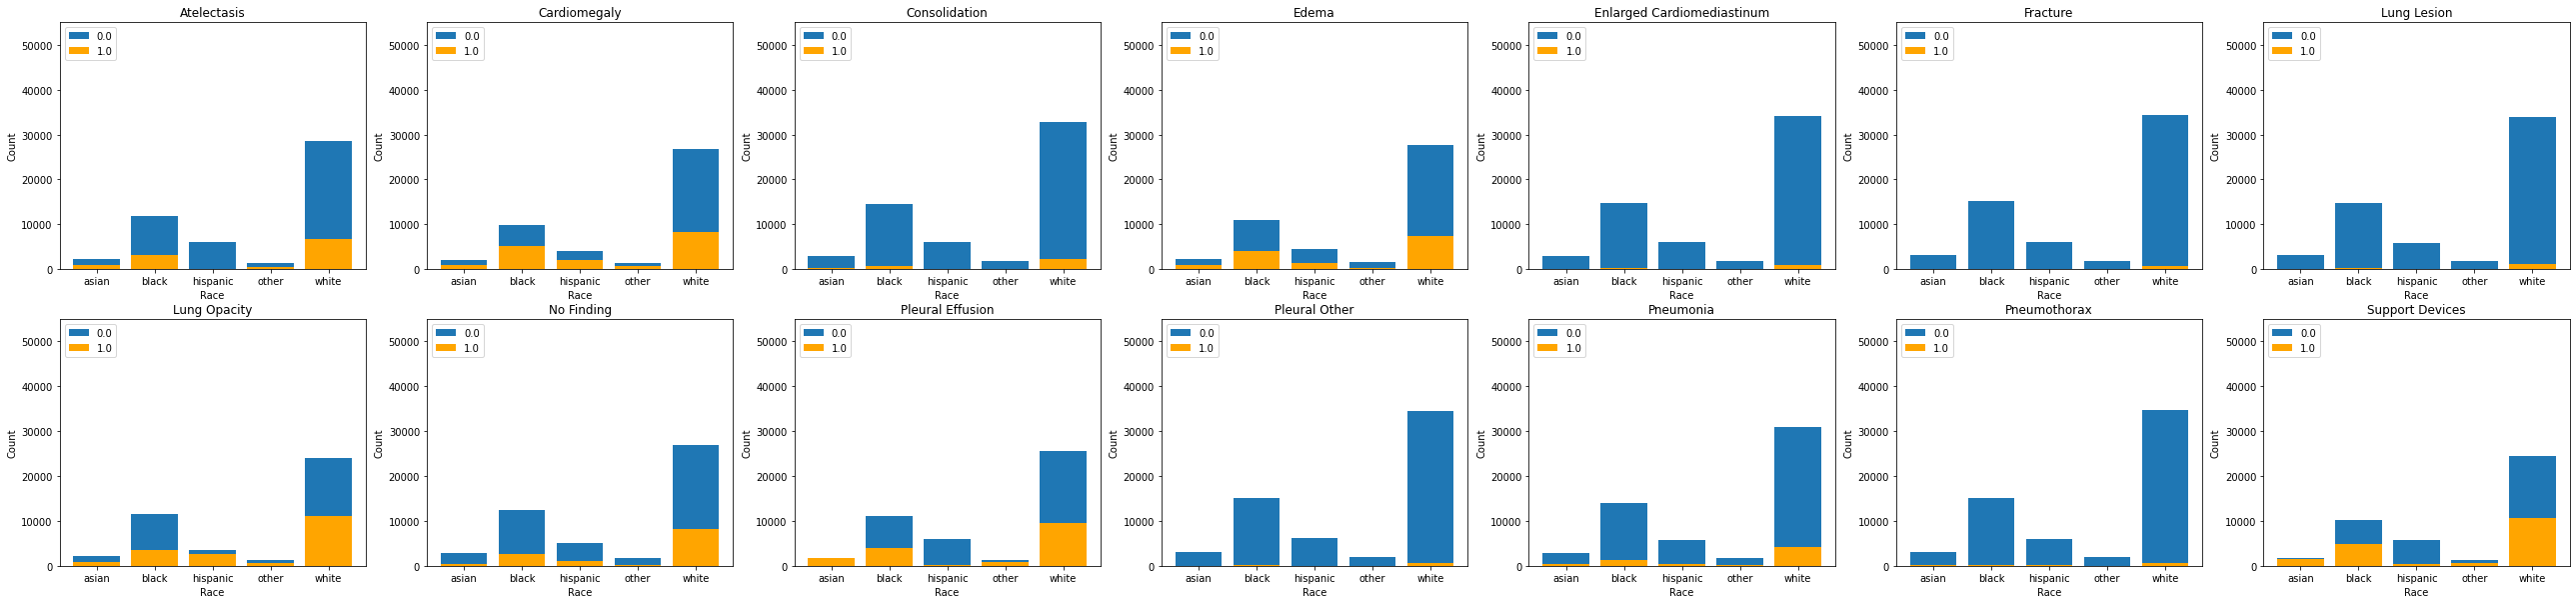

In [32]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
races = ['asian', 'black', 'hispanic', 'other', 'white']
positions = [0,1,2,3,4]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': race_dist_df.groupby([lab, 'race_bucket']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(races))
    ax[x, y].set_xticklabels(races)
    ax[x, y].set_xlabel('Race')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,55000)

plt.savefig('baseline_race_dist.png')

The next think we can do is look at the AUROC for each race-diagnosis combination, resulting in a multi-line plot for each diagnosis label.

#### AUROC

In [33]:
# Helper functions for evaluating model performance
# Generate 95% Confidence Intervals for each AUC score
def generate_CI(y_true, y_pred):

    n_bootstraps = 1000
    rng_seed = 2021  
    bootstrapped_scores = []

    rng = np.random.RandomState(rng_seed)
    for i in range(n_bootstraps):
        indices = rng.randint(0, len(y_pred), len(y_pred))
        if len(np.unique(y_true[indices])) < 2:
            continue

        score = roc_auc_score(y_true[indices], y_pred[indices])
        bootstrapped_scores.append(score)
    sorted_scores = np.array(bootstrapped_scores)
    sorted_scores.sort()
    #95% confidence interval
    confidence_lower = sorted_scores[int(0.025 * len(sorted_scores))]
    confidence_upper = sorted_scores[int(0.975 * len(sorted_scores))]
    ci_str = '[{}, {}]'.format(str(round(confidence_lower, 3)), str(round(confidence_upper, 3)))
    return ci_str

# Calculate and plot ROC
def calc_roc(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc=4)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

# calculate and plot AUPRC
def calc_prc(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = precision_recall_curve(df[lab], df['pred_'+lab])
        oauc = average_precision_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall aps={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():      
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = precision_recall_curve(ytrue, ypred)
            tauc = average_precision_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc=4)
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')


In [ ]:
calc_prc(results_baseline, 'race_bucket', labels)
plt.savefig('baseline_race_roc.png')

We can look at these results in a nested table format.

In [34]:
cols = list(labels)
cat = list(labels)
groupby = 'race_bucket'
tab = TableOne(results_baseline, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)
tab

Grouped by race_bucket                                                                               
                                                     Overall         asian         black hispanic/latino        other         white P-Value
n                                                      61571          3176         15175            6118         1989         35113        
Atelectasis, n (%)                0.0           50252 (81.6)   2303 (72.5)  11954 (78.8)     6056 (99.0)  1467 (73.8)  28472 (81.1)  <0.001
                                  1.0           11319 (18.4)    873 (27.5)   3221 (21.2)        62 (1.0)   522 (26.2)   6641 (18.9)        
Cardiomegaly, n (%)               0.0           44311 (72.0)   2152 (67.8)   9958 (65.6)     4077 (66.6)  1365 (68.6)  26759 (76.2)  <0.001
                                  1.0           17260 (28.0)   1024 (32.2)   5217 (34.4)     2041 (33.4)   624 (31.4)   8354 (23.8)        
Consolidation, n (%)              0.0           58317 (94.7)   2937 (92.5)  14527 (95.7)     6112 (99.9)  1886 (94.8)  32855 (93.6)  <0.001
                                  1.0             3254 (5.3)     239 (7.5)     648 (4.3)         6 (0.1)    103 (5.2)    2258 (6.4)        
Edema, n (%)                      0.0           47293 (76.8)   2326 (73.2)  11021 (72.6)     4622 (75.5)  1598 (80.3)  27726 (79.0)  <0.001
                                  1.0           14278 (23.2)    850 (26.8)   4154 (27.4)     1496 (24.5)   391 (19.7)   7387 (21.0)        
Enlarged Cardiomediastinum, n (%) 0.0           60048 (97.5)   3054 (96.2)  14783 (97.4)    6117 (100.0)  1918 (96.4)  34176 (97.3)  <0.001
                                  1.0             1523 (2.5)     122 (3.8)     392 (2.6)         1 (0.0)     71 (3.6)     937 (2.7)        
Fracture, n (%)                   0.0           60628 (98.5)   3093 (97.4)  15140 (99.8)     6018 (98.4)  1948 (97.9)  34429 (98.1)  <0.001
                                  1.0              943 (1.5)      83 (2.6)      35 (0.2)       100 (1.6)     41 (2.1)     684 (1.9)        
Lung Lesion, n (%)                0.0           59815 (97.1)  3175 (100.0)  14807 (97.6)     5955 (97.3)  1926 (96.8)  33952 (96.7)  <0.001
                                  1.0             1756 (2.9)       1 (0.0)     368 (2.4)       163 (2.7)     63 (3.2)    1161 (3.3)        
Lung Opacity, n (%)               0.0           42633 (69.2)   2262 (71.2)  11632 (76.7)     3437 (56.2)  1268 (63.8)  24034 (68.4)  <0.001
                                  1.0           18938 (30.8)    914 (28.8)   3543 (23.3)     2681 (43.8)   721 (36.2)  11079 (31.6)        
No Finding, n (%)                 0.0           49070 (79.7)   2845 (89.6)  12528 (82.6)     4981 (81.4)  1733 (87.1)  26983 (76.8)  <0.001
                                  1.0           12501 (20.3)    331 (10.4)   2647 (17.4)     1137 (18.6)   256 (12.9)   8130 (23.2)        
Pleural Effusion, n (%)           0.0           45283 (73.5)   1436 (45.2)  11170 (73.6)     5953 (97.3)  1218 (61.2)  25506 (72.6)  <0.001
                                  1.0           16288 (26.5)   1740 (54.8)   4005 (26.4)       165 (2.7)   771 (38.8)   9607 (27.4)        
Pleural Other, n (%)              0.0           60846 (98.8)  3176 (100.0)  15068 (99.3)     6082 (99.4)  1976 (99.3)  34544 (98.4)  <0.001
                                  1.0              725 (1.2)                   107 (0.7)        36 (0.6)     13 (0.7)     569 (1.6)        
Pneumonia, n (%)                  0.0           55154 (89.6)   2876 (90.6)  13873 (91.4)     5666 (92.6)  1755 (88.2)  30984 (88.2)  <0.001
                                  1.0            6417 (10.4)     300 (9.4)    1302 (8.6)       452 (7.4)   234 (11.8)   4129 (11.8)        
Pneumothorax, n (%)               0.0           60705 (98.6)   3074 (96.8)  15084 (99.4)     6015 (98.3)  1961 (98.6)  34571 (98.5)  <0.001
                                  1.0              866 (1.4)     102 (3.2)      91 (0.6)       103 (1.7)     28 (1.4) 

### 2. ICU Status

Another feature we wanted to stratify by is the ICU status of the patient. Generally, patients who are in the ICU tend to have more severe diagnoses, so we wanted to see if the model would perform better on ICU patients' x-rays compared to non-ICU patients.

#### Preprocessing

In [35]:
icu = pd.read_csv('/home/zzaiman/local/physionet.org/files/mimiciv/2.0/icu/icustays.csv')
metadata = pd.read_csv('../../../physionet.org/files/mimic-cxr-jpg/2.0.0/mimic-cxr-2.0.0-metadata.csv')

In [36]:
# Filter metadata to get StudyDate
metadata = metadata[['subject_id', 'study_id', 'StudyDate']]

# Convert dates to datetime. 
metadata['StudyDate'] = pd.to_datetime(metadata['StudyDate'], format='%Y%m%d')
icu['intime'] = pd.to_datetime(icu['intime'])
icu['outtime'] = pd.to_datetime(icu['outtime'])

# Merge with ICU and filter for all study dates in an ICU stay for the same patient.
metadata_icu = metadata.merge(icu, on='subject_id')
metadata_icu = metadata_icu[(metadata_icu['StudyDate'] >= metadata_icu['intime']) & (metadata_icu['StudyDate'] <= metadata_icu['outtime'])].reset_index(drop=True)

In [37]:
metadata_icu.nunique()

subject_id        10057
study_id          47773
StudyDate         22872
hadm_id           11868
stay_id           12896
first_careunit        8
last_careunit         8
intime            12896
outtime           12896
los               12778
dtype: int64

In [38]:
# Drop duplicates on study ID since all patients in this df are in the ICU.
metadata_icu = metadata_icu.drop_duplicates(subset=['study_id'])
metadata_icu.shape

(47773, 10)

#### AUROC

In [39]:
metadata_icu['study_in_icu'] = 1
metadata_icu_studies = metadata_icu[['study_id', 'study_in_icu']]
results_icu = results_baseline.merge(metadata_icu_studies, on='study_id', how='left')
results_icu['study_in_icu'].fillna(0, inplace=True)
results_icu['study_in_icu'].value_counts()

0.0    49033
1.0    12538
Name: study_in_icu, dtype: int64

In [ ]:
calc_roc(results_icu, 'study_in_icu', labels)
plt.savefig('baseline_icu_roc.png')

We can also view the same result in table format, as seen below.

In [40]:
cols = list(labels)
cat = list(labels)
groupby = 'study_in_icu'
tab = TableOne(results_icu, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)
tab

Grouped by study_in_icu                                    
                                                      Overall           0.0           1.0 P-Value
n                                                       61571         49033         12538        
Atelectasis, n (%)                0.0            50252 (81.6)  42170 (86.0)   8082 (64.5)  <0.001
                                  1.0            11319 (18.4)   6863 (14.0)   4456 (35.5)        
Cardiomegaly, n (%)               0.0            44311 (72.0)  37245 (76.0)   7066 (56.4)  <0.001
                                  1.0            17260 (28.0)  11788 (24.0)   5472 (43.6)        
Consolidation, n (%)              0.0            58317 (94.7)  46561 (95.0)  11756 (93.8)  <0.001
                                  1.0              3254 (5.3)    2472 (5.0)     782 (6.2)        
Edema, n (%)                      0.0            47293 (76.8)  38924 (79.4)   8369 (66.7)  <0.001
                                  1.0            14278 (23.2)  10109 (20.6)   4169 (33.3)        
Enlarged Cardiomediastinum, n (%) 0.0            60048 (97.5)  48211 (98.3)  11837 (94.4)  <0.001
                                  1.0              1523 (2.5)     822 (1.7)     701 (5.6)        
Fracture, n (%)                   0.0            60628 (98.5)  48161 (98.2)  12467 (99.4)  <0.001
                                  1.0               943 (1.5)     872 (1.8)      71 (0.6)        
Lung Lesion, n (%)                0.0            59815 (97.1)  47577 (97.0)  12238 (97.6)   0.001
                                  1.0              1756 (2.9)    1456 (3.0)     300 (2.4)        
Lung Opacity, n (%)               0.0            42633 (69.2)  34553 (70.5)   8080 (64.4)  <0.001
                                  1.0            18938 (30.8)  14480 (29.5)   4458 (35.6)        
No Finding, n (%)                 0.0            49070 (79.7)  37730 (76.9)  11340 (90.4)  <0.001
                                  1.0            12501 (20.3)  11303 (23.1)    1198 (9.6)        
Pleural Effusion, n (%)           0.0            45283 (73.5)  38827 (79.2)   6456 (51.5)  <0.001
                                  1.0            16288 (26.5)  10206 (20.8)   6082 (48.5)        
Pleural Other, n (%)              0.0            60846 (98.8)  48411 (98.7)  12435 (99.2)  <0.001
                                  1.0               725 (1.2)     622 (1.3)     103 (0.8)        
Pneumonia, n (%)                  0.0            55154 (89.6)  43862 (89.5)  11292 (90.1)   0.049
                                  1.0             6417 (10.4)   5171 (10.5)    1246 (9.9)        
Pneumothorax, n (%)               0.0            60705 (98.6)  48365 (98.6)  12340 (98.4)   0.072
                                  1.0               866 (1.4)     668 (1.4)     198 (1.6)        
Support Devices, n (%)            0.0            43557 (70.7)  39440 (80.4)   4117 (32.8)  <0.001
                                  1.0            18014 (29.3)   9593 (19.6)   8421 (67.2)

### 3. Sex

We are also interested in stratifying the model's performane based on sex, since anatomically, men and women have different body structures which may influence the model's predictions. Note, the dataset uses gender to indicate sex, so that is the variable we will be subsetting on, operating under the assumption that the two are synonymous.

In [41]:
results_baseline['gender'].unique()


array(['M', 'F'], dtype=object)

##### AUROC

In [ ]:
calc_roc(results_baseline, 'gender', labels)
plt.savefig('baseline_sex_roc.png')

In [42]:
cols = list(labels)
cat = list(labels)
groupby = 'gender'
tab = TableOne(results_baseline, columns=cols, categorical=cat, groupby=groupby, missing=False, pval=True)
tab

Grouped by gender                                    
                                                Overall             F             M P-Value
n                                                 61571         31024         30547        
Atelectasis, n (%)                0.0      50252 (81.6)  23964 (77.2)  26288 (86.1)  <0.001
                                  1.0      11319 (18.4)   7060 (22.8)   4259 (13.9)        
Cardiomegaly, n (%)               0.0      44311 (72.0)  22162 (71.4)  22149 (72.5)   0.003
                                  1.0      17260 (28.0)   8862 (28.6)   8398 (27.5)        
Consolidation, n (%)              0.0      58317 (94.7)  29727 (95.8)  28590 (93.6)  <0.001
                                  1.0        3254 (5.3)    1297 (4.2)    1957 (6.4)        
Edema, n (%)                      0.0      47293 (76.8)  23269 (75.0)  24024 (78.6)  <0.001
                                  1.0      14278 (23.2)   7755 (25.0)   6523 (21.4)        
Enlarged Cardiomediastinum, n (%) 0.0      60048 (97.5)  30255 (97.5)  29793 (97.5)   0.954
                                  1.0        1523 (2.5)     769 (2.5)     754 (2.5)        
Fracture, n (%)                   0.0      60628 (98.5)  30563 (98.5)  30065 (98.4)   0.370
                                  1.0         943 (1.5)     461 (1.5)     482 (1.6)        
Lung Lesion, n (%)                0.0      59815 (97.1)  30405 (98.0)  29410 (96.3)  <0.001
                                  1.0        1756 (2.9)     619 (2.0)    1137 (3.7)        
Lung Opacity, n (%)               0.0      42633 (69.2)  22889 (73.8)  19744 (64.6)  <0.001
                                  1.0      18938 (30.8)   8135 (26.2)  10803 (35.4)        
No Finding, n (%)                 0.0      49070 (79.7)  23556 (75.9)  25514 (83.5)  <0.001
                                  1.0      12501 (20.3)   7468 (24.1)   5033 (16.5)        
Pleural Effusion, n (%)           0.0      45283 (73.5)  22130 (71.3)  23153 (75.8)  <0.001
                                  1.0      16288 (26.5)   8894 (28.7)   7394 (24.2)        
Pleural Other, n (%)              0.0      60846 (98.8)  30690 (98.9)  30156 (98.7)   0.021
                                  1.0         725 (1.2)     334 (1.1)     391 (1.3)        
Pneumonia, n (%)                  0.0      55154 (89.6)  28318 (91.3)  26836 (87.9)  <0.001
                                  1.0       6417 (10.4)    2706 (8.7)   3711 (12.1)        
Pneumothorax, n (%)               0.0      60705 (98.6)  30765 (99.2)  29940 (98.0)  <0.001
                                  1.0         866 (1.4)     259 (0.8)     607 (2.0)        
Support Devices, n (%)            0.0      43557 (70.7)  20927 (67.5)  22630 (74.1)  <0.001
                                  1.0      18014 (29.3)  10097 (32.5)   7917 (25.9)

### 4. Age

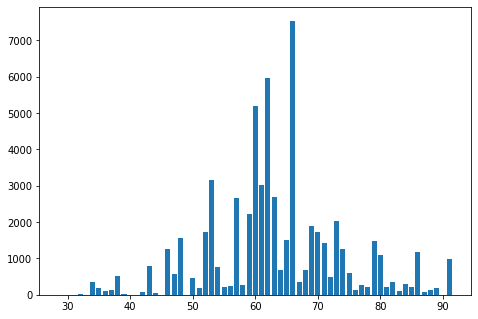

In [62]:
age_dist = results_baseline['anchor_age'].value_counts().sort_index()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_dist.index, age_dist.values)
plt.show()

Age can be correlated with many health outcomes. "Anchor age" provided in this dataset is not exact but roughly reflects (~2 years) the patient's age for the purpose of anonymization. All patients older than 89 years have 91 as their anchor age, which explains the relatively high incident of that age in the distribution. Since this is hospital patient data, the age distribution skews older, with the youngest recorded anchor age being 29.

#### Preprocessing

In [48]:
#Generating age buckets
def age_groups(x):
    if x['anchor_age'] < 30:
        return '20-29'
    if x['anchor_age'] < 40:
        return '30-39'
    if x['anchor_age'] < 50:
        return '40-49'
    if x['anchor_age'] < 60:
        return '50-59'
    if x['anchor_age'] < 70:
        return '60-69'
    if x['anchor_age'] < 80:
        return '70-79'
    if x['anchor_age'] < 90:
        return '80-89'
    else: return '90+'

results_baseline['age_cohort'] = results_baseline.apply(lambda row: age_groups(row), axis=1)
age_cohort_dist = results_baseline['age_cohort'].value_counts().sort_index()

Plotting the distribution of age buckets:

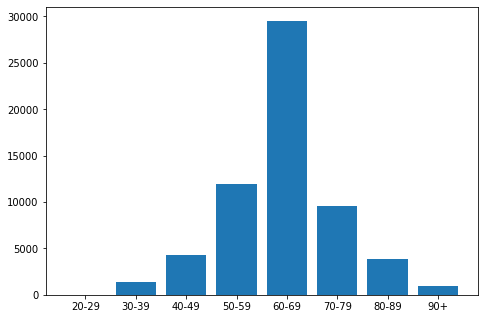

In [49]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(age_cohort_dist.index, age_cohort_dist.values)
plt.show()

In [50]:
#It is not visible in the chart but there are actually a few patients under 30
age_cohort_dist[age_cohort_dist<30]

20-29    3
Name: age_cohort, dtype: int64

We can plot a distribution for each diagnostic label

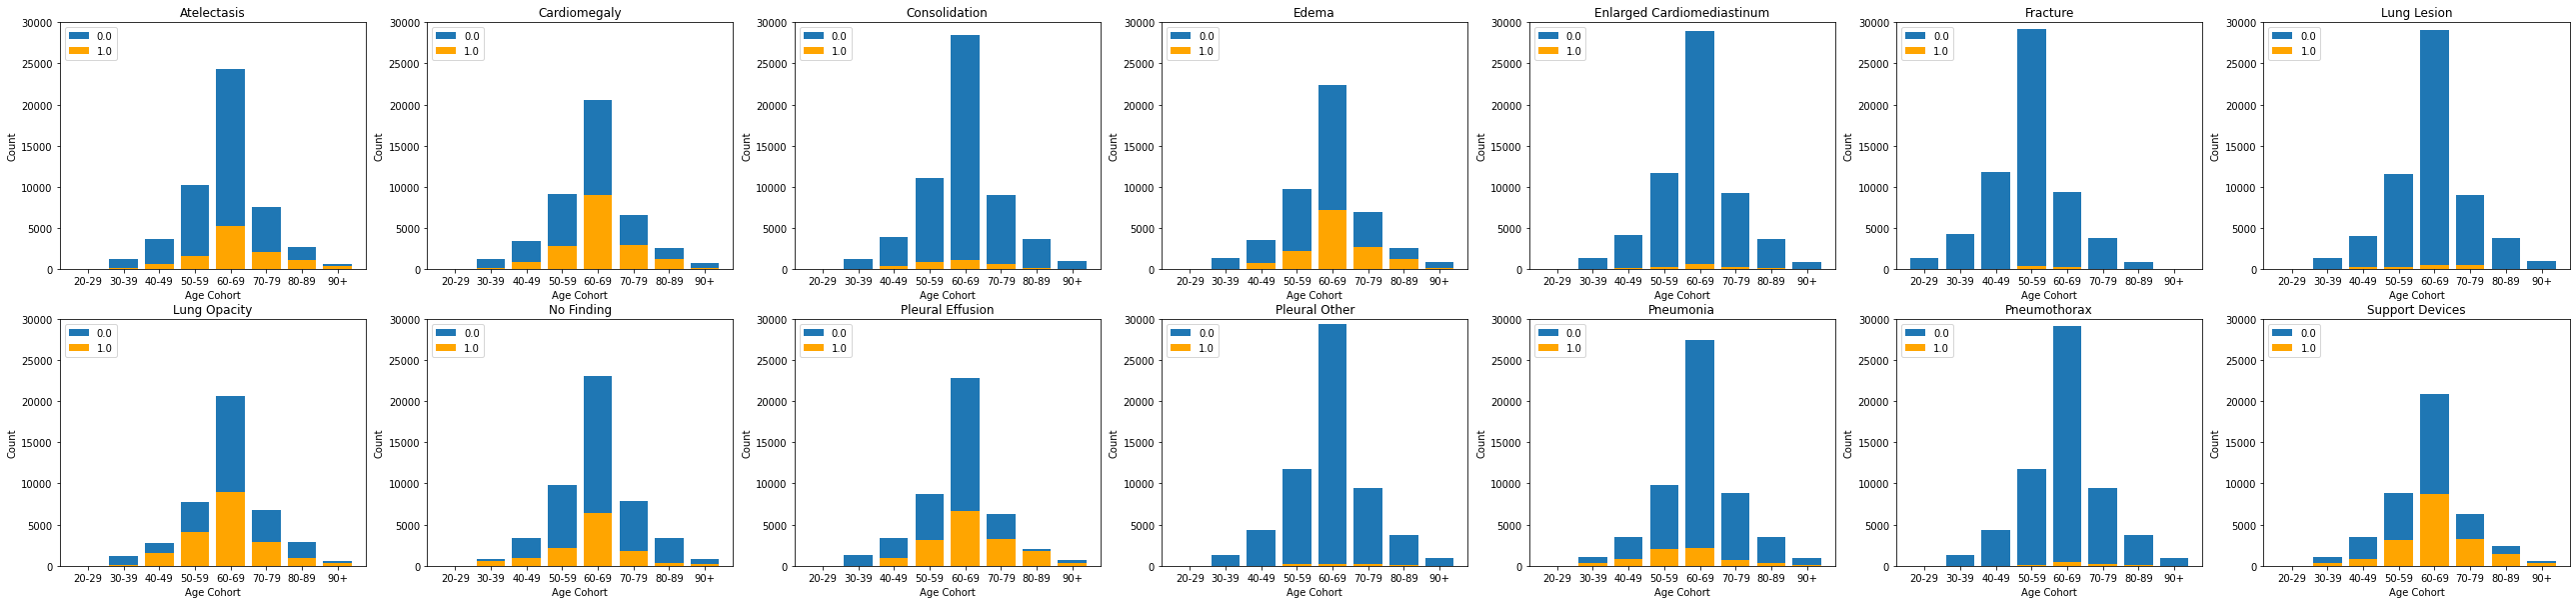

In [51]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
cohort = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']
positions = [0,1,2,3,4,5,6,7]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results_baseline.groupby([lab, 'age_cohort']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(cohort))
    ax[x, y].set_xticklabels(cohort)
    ax[x, y].set_xlabel('Age Cohort')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,30000)

plt.savefig('baseline_age_dist_plots.png')

_Initial observations: Labels "No Finding" and "Pneumonia" are disproportinately common for younger age cohorts. Pleural Effusion, Support Devices, and Atelectasis are disproportinately common for older age cohorts._

In [63]:
# I modified the plotting function a little bit 
# so that the grpahs aren't covered by the legend
def calc_roc_age(df, strata, labels):
    fpr = {}
    tpr = {}
    auc = {}
    fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(30, 10))
    plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    hspace=0.97,
                    wspace=0.2)
    for i, lab in enumerate(labels):
        if i < 7:
            x = 0
        else:
            x = 1
        if i < 7:
            y = i
        else:
            y = i - 7
        otpr, ofpr, _, = roc_curve(df[lab], df['pred_'+lab])
        oauc = roc_auc_score(df[lab], df['pred_'+lab])
        ci = generate_CI(df[lab], df['pred_'+lab])
        ax[x, y].plot(otpr, ofpr, label=f'Overall auc={round(oauc, 2)} ci={ci}')
        for category in df[strata].unique():
            tmp = df[df[strata] == category].reset_index(drop=True)
            ytrue = tmp[lab]
            if len(np.unique(ytrue)) == 1:
                print(f"Dropped strata: {category} in class {lab}", flush=True)
                continue

            ypred = tmp['pred_'+lab]
            tfpr, ttpr, _ = roc_curve(ytrue, ypred)
            tauc = roc_auc_score(ytrue, ypred)
            fpr[str(category) + '_' + lab] = tfpr
            tpr[str(category) + '_' + lab] = ttpr
            auc[str(category) + '_' + lab] = tauc
            tci = generate_CI(ytrue, ypred)
            ax[x, y].plot(tfpr, ttpr, label=f'{str(category)} auc={round(tauc, 2)}, ci={tci}')
            ax[x, y].title.set_text(lab)
            ax[x, y].legend(loc = 8, bbox_to_anchor=(0.5, -0.82))
            
            ax[x, y].set_xlabel('FPR')
            ax[x, y].set_ylabel('TPR')

In [ ]:
calc_roc_age(results_focal, 'age_cohort', labels)
plt.savefig('baseline_age_plots.png')

### 5. Insurance Provider

In [64]:
results_baseline['insurance'].value_counts()

Medicare    38485
Other       19488
Medicaid     3598
Name: insurance, dtype: int64

A patient's insurance provider can often overlap with the patient's socioeconomic status and/or age and therefore health outcomes. For example, low-income individuals are eligible to receive Medicaid, while patients who have Medicare as their insurance provider are either over 65 or have disabilitiess. "Other" refers to private insurance which is connected to active employment and/or higher income.

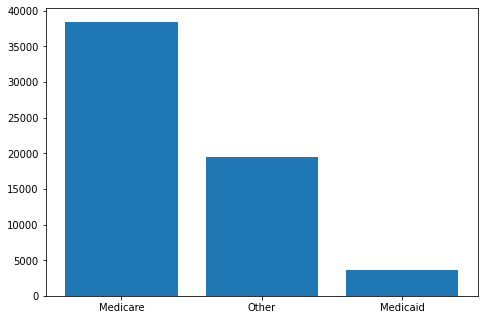

In [65]:
insurance_dist = results_baseline['insurance'].value_counts()
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(insurance_dist.index, insurance_dist.values)
plt.show()

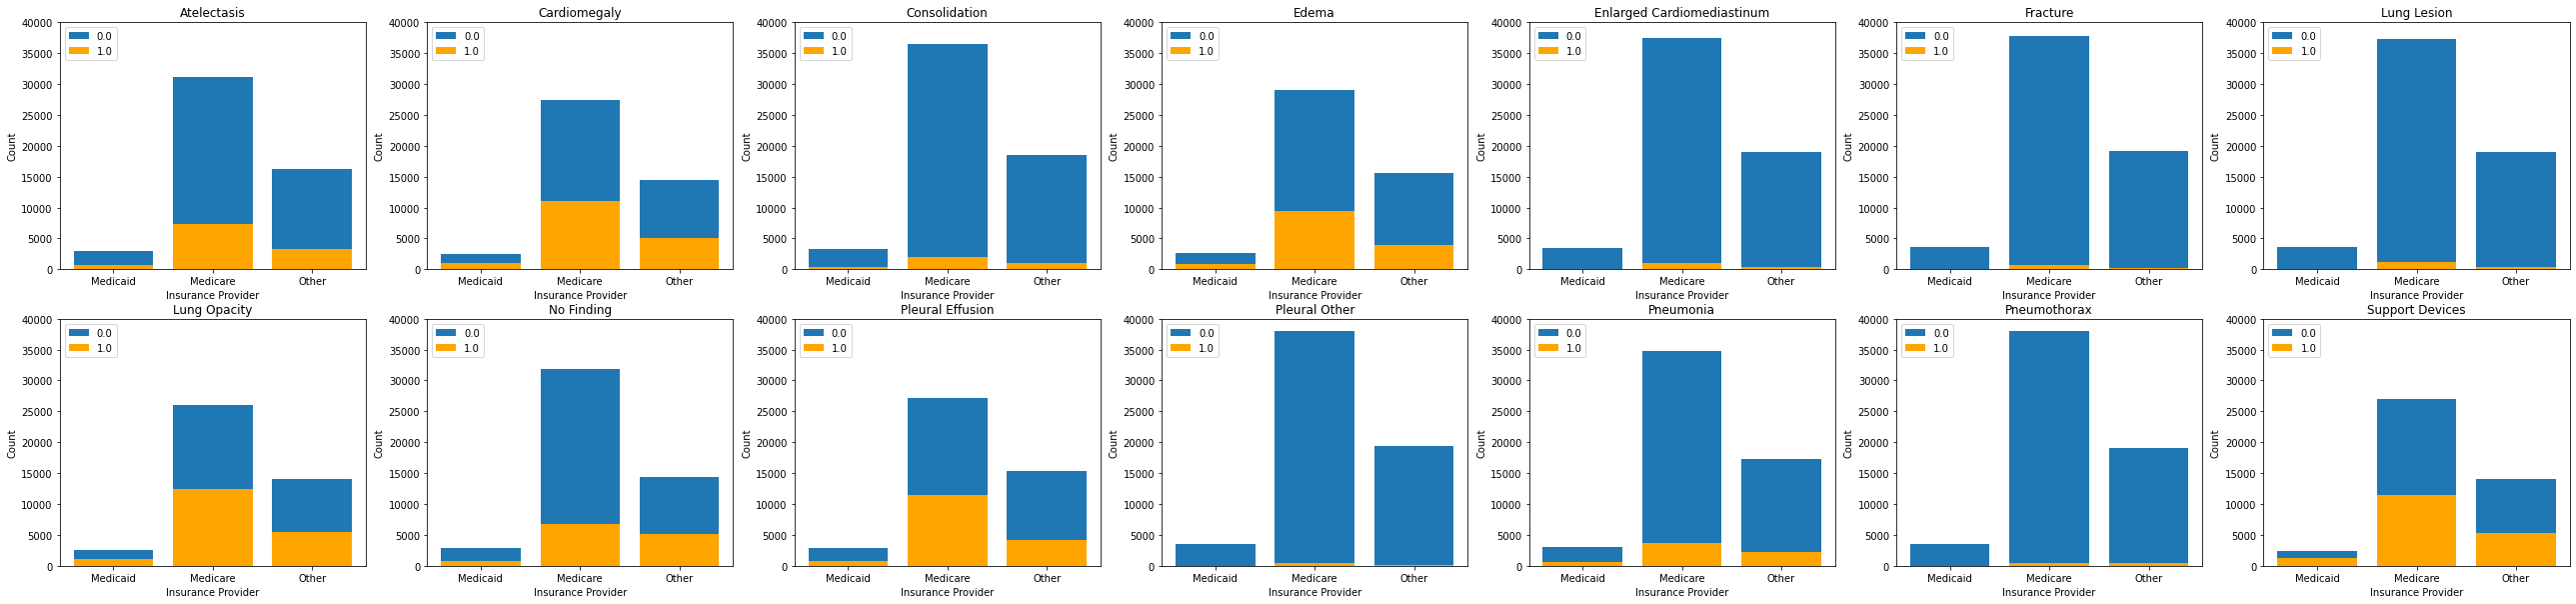

In [66]:
from matplotlib import ticker
fig, ax = plt.subplots(nrows=2, ncols=7, figsize=(45, 10))
insurance = ['Medicaid', 'Medicare', 'Other']
positions = [0,1,2]
for i, lab in enumerate(labels):
    if i < 7:
        x = 0
    else:
        x = 1
    if i < 7:
        y = i
    else:
        y = i - 7

    a = pd.DataFrame({'count': results_baseline.groupby([lab, 'insurance']).size()}).reset_index()
    neg_df = a[a[lab] == 0.0].iloc[:, 1:]
    pos_df = a[a[lab] == 1.0].iloc[:, 1:]
    ax[x,y].bar(neg_df.iloc[:,0], neg_df.iloc[:,1], label='0.0')
    ax[x,y].bar(pos_df.iloc[:,0], pos_df.iloc[:,1], color='orange', label='1.0')
    ax[x, y].title.set_text(lab)
    ax[x, y].legend(loc=2)
    ax[x, y].xaxis.set_major_locator(ticker.FixedLocator(positions))
    ax[x, y].xaxis.set_major_formatter(ticker.FixedFormatter(insurance))
    ax[x, y].set_xticklabels(insurance)
    ax[x, y].set_xlabel('Insurance Provider')
    ax[x, y].set_ylabel('Count')
    ax[x, y].set_ylim(0,40000)
    plt.savefig('baseline_insurance_dist_plots.png')

_Initial observation: Medicaid people have a disproportionate number of support devices (more than half). Medicare people seem to disproportionately have Pleural Effusion (close to half)._

In [ ]:
calc_roc(results_baseline, 'insurance', labels)
plt.savefig('baseline_insurance_plots.png')